# F1 EDA
#### PART 1: 

Here I answer some questions regarding drivers, races, and seasons.

In [65]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExNWl6ajhnaDU4aHVteGpmamk2Z3BkdXd3NDFwY3BybG9uMHB2MzZtcSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/sA50TO4Ew7QXu/giphy.gif")

## 1) Importing Packages and Data

In [66]:
import pandas as pd
import numpy as np
import F1_Preprocessing #Internal package to preprocess data
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

np.random.seed(1994)

In [67]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "1_API_Requests_Ergast.py"

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

ResultsDF=pd.read_csv(path+"ResultsDF.csv")
QualifyingDF=pd.read_csv(path+"QualifyingDF.csv")
LapsDF=pd.read_csv(path+"LapsDF.csv")
PitsDF=pd.read_csv(path+"PitsDF.csv")

C:\Users\gabri\AppData\Local\Temp\ipykernel_32180\478565046.py:8: DtypeWarning:

Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.



## 2) Data Preprocessing

In [68]:
# Apply the data preprocessing for each df using a function stored in the repo. 
# This is done this way so the preprocessing is consistent throughout all notebooks.
ResultsDF=F1_Preprocessing.preprocess_F1results(ResultsDF)
LapsDF=F1_Preprocessing.preprocess_F1laps(LapsDF)
PitsDF=F1_Preprocessing.preprocess_F1pits(PitsDF)

In [69]:
# Merging features between dfs

# Laps and Pits
Laps_Pits=pd.merge(LapsDF,PitsDF[["season","round","driverid","pit_stop_lap_number","pit_stop_time","pit_stop_duration_in_milliseconds","pit_stop_number"]],
                   left_on=["driverid","season","round","current_lap_number"],
                   right_on=["driverid","season","round","pit_stop_lap_number"],how="left")

# We only have information of the pit stops from 2012, so Laps_Pits will have instances from 2012 or later
Laps_Pits=Laps_Pits[Laps_Pits["season"]>=2012]

# Merging with Results df
SelectedResults=ResultsDF[['final_position', 'final_points', 'final_grid', 'final_laps', 'final_status', 'driverid','driver.nationality', 'constructor.constructorid', 'constructor.nationality', 'race_time.millis','fastestlap.rank', 'fastestlap.lap','fastestlap.time.time', 'fastestlap.averagespeed.units','fastestlap.averagespeed.speed', 'season', 'round','fastestlap.time.in_milliseconds', 'season-round','circuit.circuitid_encoded', 'constructor.constructorid_encoded','driverid_encoded']]

Laps_Pits_Results=pd.merge(Laps_Pits,SelectedResults,on=["driverid","season","round"],how="left")


In [70]:
# Adding extra features

#Feature created to indicated if the lap is the fastest or not
Laps_Pits_Results['IsFastestLap']=np.where(Laps_Pits_Results['current_lap_number'] == Laps_Pits_Results['fastestlap.lap'], 1, 0)
Laps_Pits_Results['IsPitStopLap']=np.where(Laps_Pits_Results['current_lap_number'] == Laps_Pits_Results['pit_stop_lap_number'], 1, 0)

## 3) Answering some questions with EDA

### A. How fast are the cars now?


##### Distributon of the fastest lap per round (race) per driver from season 2014 to 2024 

In this graph we can see the fastest lap, per race, per driver, and per season. The label at the bottom of each season shows the name of the driver who did the fastest lap of the year and the name of the circuit of the fastest lap.

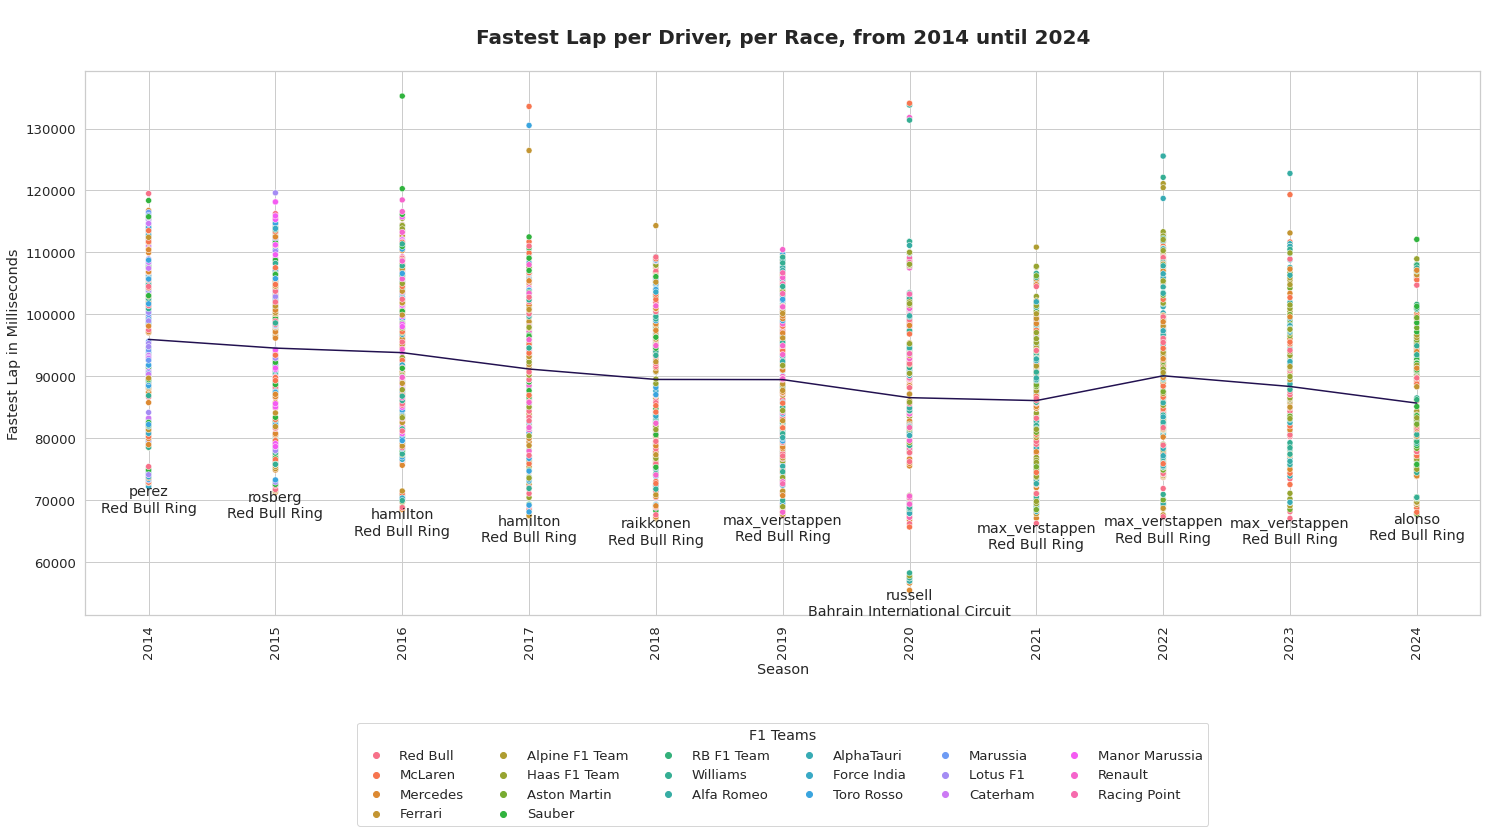

In [100]:
sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

From_Season=2014
DF=ResultsDF[(ResultsDF["season"]>=From_Season)&(ResultsDF["fastestlap.time.in_milliseconds"]<140000)] #filter for viz reasons

#Fastest lap per driver per season
fastest_lap_per_season=DF.groupby(["season"])["fastestlap.time.in_milliseconds"].min().reset_index().rename(columns={"fastestlap.time.in_milliseconds":"fastestlap_season"})
labels_df=ResultsDF.merge(fastest_lap_per_season,on="season",how="left")
labels_df=labels_df[labels_df["fastestlap.time.in_milliseconds"]==labels_df["fastestlap_season"]].reset_index()[["driverid","circuit.circuitname","fastestlap.time.in_milliseconds","season"]].drop_duplicates()


#Plot
fig, ax = plt.subplots(figsize=(25, 10))
sns.scatterplot(x="season", y="fastestlap.time.in_milliseconds",hue='constructor.name',ci=None,estimator="min",markers=True,data=DF)
sns.lineplot(x="season", y="fastestlap.time.in_milliseconds",estimator="mean",ci=None,data=DF)

ax.set(xlabel="Season", ylabel="Fastest Lap in Milliseconds")
ax.set_title("\n Fastest Lap per Driver, per Race, from 2014 until 2024 \n",fontsize=20,fontweight='bold')

seasons = DF["season"].unique()
ax.set_xticks(seasons)
ax.set_xticklabels(seasons, rotation=90)  
ax.locator_params(axis="x", nbins=len(seasons))

ax.legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', title="F1 Teams", ncol=6)

# Annotattions:
for driver, circuit, time, season in labels_df.to_numpy():
    label = f"{driver}\n{circuit}"
    ax.annotate(label, 
                (season, time), 
                textcoords="offset points", 
                xytext=(0, -25),
                ha='center')

plt.show()


The above graph is good to give an idea of how fast the cars run. We can see that the cars are getting faster and that the Red Bull Ring is the one with the shortest lap of the calendar. 

In the graph below we can see the fastest lap by driver and filter by circuit using the legend.

In [111]:
# Filter data
From_Season = 2014
DF = ResultsDF[(ResultsDF["season"] >= From_Season)]

fig = px.scatter(DF, x='season', y='fastestlap.time.in_milliseconds',color='circuit.circuitname',hover_data=['constructor.name','driverid'])

# Update layout
fig.update_layout(xaxis_title="Season",
                  yaxis_title="Fastest Lap Time (Milliseconds)",
                  title_text=f"Fastest Laps by circuit (2014-2024)",
                  title_font=dict(size=24, color='black', weight='bold'), 
                  title_x=0.5,
                  legend_title="Circuit")

# Show the interactive plot
fig.show()
